In [1]:
import pandas
import math
import scipy.misc

import numpy as np

from PIL import Image
import os
import numpy as np
import scipy.misc

import json

import shapely.geometry
from geopandas_osm import osm
from shapely.geometry import shape

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2

from shapely.wkt import loads

import pandas as pd
import json

import geojson
import geopandas as gpd
from geojson import Feature, Point, FeatureCollection

Using TensorFlow backend.


In [2]:
def tile2long(x,z):
    return x / math.pow(2, z) * 360 - 180

def tile2lat(y,z):
    n = math.pi - 2 * math.pi * y / math.pow(2, z)
    return 180 / math.pi * math.atan(0.5 * (math.exp(n) - math.exp(-n)))

lat_tile_gap = 0.01247771997
lon_tile_gap = 0.02197265625
# lat_tile_gap = 0.02
# lon_tile_gap = 0.04

**create poly from sentinel**

In [32]:
tile_base_path = '../media/combined_37_UDB/'

z = '14'
x = '9918'
y = '11246'

file_path = tile_base_path + '%s/%s/%s.png' % (z, x, y)

tile_lat_min, tile_long_min = abs(tile2lat(float(y), float(z))), tile2long(float(x), float(z))
tile_lat_max, tile_long_max = tile_lat_min + lat_tile_gap, tile_long_min + lon_tile_gap

print(tile_lat_min, tile_long_min)
print(tile_lat_max, tile_long_max)

55.5534954584537 37.9248046875
55.565973178423704 37.94677734375


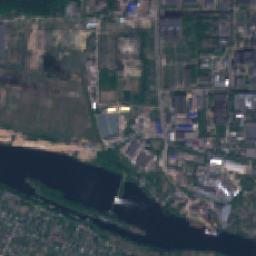

In [33]:
Image.open(file_path)

In [34]:
o = {
#     "coordinates": [[[tile_lat_min, tile_long_min], [tile_lat_max, tile_long_min], [tile_lat_max, tile_long_max], [tile_lat_min, tile_long_max], [tile_lat_min, tile_long_min]]], 
    "coordinates": [[[tile_long_min, tile_lat_min], [tile_long_min, tile_lat_max], [tile_long_max, tile_lat_max], [tile_long_max, tile_lat_min], [tile_long_min, tile_lat_min]]], 
   "type": "Polygon"
}

In [35]:
s = json.dumps(o)

# Convert to geojson.geometry.Polygon
g1 = geojson.loads(s)

# Feed to shape() to convert to shapely.geometry.polygon.Polygon
# This will invoke its __geo_interface__ (https://gist.github.com/sgillies/2217756)
g2 = shape(g1)

In [36]:
my_feature = Feature(geometry=g2)

In [37]:
collection = FeatureCollection([my_feature])

In [38]:
col = gpd.GeoDataFrame.from_features(collection['features'])
col

,geometry
0,"POLYGON ((37.9248046875 55.5534954584537, 37.9..."


**download tags from osm**

In [42]:
tag = 'waterway'
try:
    df = osm.query_osm('way', col.ix[0].geometry, recurse='down', tags=tag)
except Exception:
    df = pd.DataFrame(columns=['type', tag, 'geometry'])
    
roads = df[df.type == 'LineString'][[tag, 'geometry']]

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\geopandas_osm\osm.py:299: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [43]:
roads.head()

,waterway,geometry
0,dam,"LINESTRING (37.9354857 55.5573926, 37.9348124 ..."
1,canal,"LINESTRING (37.9281922 55.5563539, 37.9322412 ..."
2,river,"LINESTRING (37.9244862 55.5580996, 37.9265185 ..."
3,river,"LINESTRING (37.9322412 55.5553841, 37.9349299 ..."
4,river,"LINESTRING (37.793561 55.6229597, 37.7940859 5..."


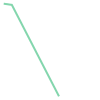

In [44]:
roads.geometry.values[5]

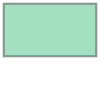

In [45]:
si = col.ix[0].geometry
si

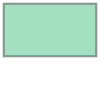

In [46]:
col.ix[0].geometry.union(roads.geometry.values[0])

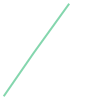

In [47]:
col.ix[0].geometry.intersection(roads.geometry.values[0])

**coords to raster**

In [48]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [49]:
col

,geometry
0,"POLYGON ((37.9248046875 55.5534954584537, 37.9..."


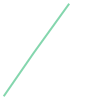

In [50]:
roads.geometry.values[0]

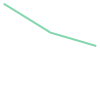

In [51]:
col.ix[0].geometry.intersection(roads.geometry.values[2])

In [52]:
inter = []
for geom in roads.geometry.values:
    a = col.ix[0].geometry.intersection(geom)
    if a.type == 'LineString':
        inter.append(a)
# todo: handle multilinestring, polygons

In [53]:
c = [np.array(list(x.coords)) for x in inter]
for i in range(len(c)):
    c[i][:, 1] = c[i][:, 1] - tile_lat_min
    c[i][:, 0] = c[i][:, 0] - tile_long_min

In [54]:
c_raster = [_convert_coordinates_to_raster(x, [256.0, 256.0], [lon_tile_gap, lat_tile_gap]) for x in c]

**visualize**

In [55]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    for perim in perim_list:
        for line_index in range(0, len(perim) - 1):
            cv2.line(img_mask, tuple(perim[line_index]), tuple(perim[line_index + 1]), class_value)
    return img_mask

In [62]:
masks = _plot_mask_from_contours([256, 256], [c_raster, []])

In [64]:
masks = np.asarray(np.flip(np.matrix(masks), axis = 0) * 255)

In [67]:
masks

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [69]:
for i in masks:
#     print(i)
    for j in i:
        print(j)
        break
    
    break

0


In [73]:
np.zeros([256, 256, 3], np.uint8)[0][0]

array([0, 0, 0], dtype=uint8)

In [78]:
masks

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [77]:
masks.sum()

167025

In [79]:
res = np.zeros([256, 256, 3], np.uint8)
for i, ri in enumerate(masks):
    for j, rj in enumerate(ri):
        res[i][j] = [0, 0, rj]


In [80]:
res.sum()

167025

In [81]:
scipy.misc.imsave('my.png', res)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


# remove files
# del /s /q *_mask_highway.png

# Prod

In [27]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [28]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    for perim in perim_list:
        for line_index in range(0, len(perim) - 1):
            cv2.line(img_mask, tuple(perim[line_index]), tuple(perim[line_index + 1]), class_value)
    return img_mask

In [82]:
z = '14'
tile_base_path = '../media/combined_37_UDB/%s' % z
tag = 'waterway'

In [83]:
start_index = 0
for x in os.listdir(tile_base_path)[start_index:]:
    for y in os.listdir(tile_base_path + '/' + str(x) + '/'):
        
        if 'mask' in y:
            continue
        
        y = y.strip('.png')
        
        tile_lat_min, tile_long_min = abs(tile2lat(float(y), float(z))), tile2long(float(x), float(z))
        tile_lat_max, tile_long_max = tile_lat_min + lat_tile_gap, tile_long_min + lon_tile_gap
        
        o = {
                "coordinates": [[[tile_long_min, tile_lat_min], [tile_long_min, tile_lat_max], [tile_long_max, tile_lat_max], [tile_long_max, tile_lat_min], [tile_long_min, tile_lat_min]]], 
               "type": "Polygon"
            }
        
        s = json.dumps(o)
        g1 = geojson.loads(s)
        g2 = shape(g1)
        
        my_feature = Feature(geometry=g2)
        collection = FeatureCollection([my_feature])
        col = gpd.GeoDataFrame.from_features(collection['features'])

        try:
            df = osm.query_osm('way', col.ix[0].geometry, recurse='down', tags=tag)
        except Exception:
            continue
        roads = df[df.type == 'LineString'][[tag, 'geometry']]
    
        inter = []
        for geom in roads.geometry.values:
            a = col.ix[0].geometry.intersection(geom)
            if a.type == 'LineString':
                inter.append(a)

        try:
            c = [np.array(list(i.coords)) for i in inter]
        except TypeError:
            c = [np.array(list(i.coords)) for i in inter]
        for i in range(len(c)):
            c[i][:, 1] = c[i][:, 1] - tile_lat_min
            c[i][:, 0] = c[i][:, 0] - tile_long_min
        c_raster = [_convert_coordinates_to_raster(i, [256.0, 256.0], [lon_tile_gap, lat_tile_gap]) for i in c]
        
        masks = _plot_mask_from_contours([256, 256], [c_raster, []])
        masks = np.asarray(np.flip(np.matrix(masks), axis = 0) * 255)
        
        res = np.zeros([256, 256, 3], np.uint8)
        for i, ri in enumerate(masks):
            for j, rj in enumerate(ri):
                res[i][j] = [0, 0, rj]
        
        scipy.misc.imsave(tile_base_path + '/%s/%s_mask_%s.png' % (x, y, tag), res)
        
        print(tile_base_path + '/%s/%s_mask_%s.png' % (x, y, tag), 'done')

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\geopandas_osm\osm.py:299: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


../media/combined_37_UDB/14/9906/11209_mask_waterway.png done
../media/combined_37_UDB/14/9906/11210_mask_waterway.png done
../media/combined_37_UDB/14/9906/11211_mask_waterway.png done
../media/combined_37_UDB/14/9906/11214_mask_waterway.png done
../media/combined_37_UDB/14/9906/11215_mask_waterway.png done
../media/combined_37_UDB/14/9906/11216_mask_waterway.png done
../media/combined_37_UDB/14/9906/11221_mask_waterway.png done
../media/combined_37_UDB/14/9906/11223_mask_waterway.png done
../media/combined_37_UDB/14/9906/11224_mask_waterway.png done
../media/combined_37_UDB/14/9906/11225_mask_waterway.png done
../media/combined_37_UDB/14/9906/11226_mask_waterway.png done
../media/combined_37_UDB/14/9906/11227_mask_waterway.png done
../media/combined_37_UDB/14/9906/11229_mask_waterway.png done
../media/combined_37_UDB/14/9906/11230_mask_waterway.png done
../media/combined_37_UDB/14/9906/11231_mask_waterway.png done
../media/combined_37_UDB/14/9906/11237_mask_waterway.png done
../media

../media/combined_37_UDB/14/9910/11221_mask_waterway.png done
../media/combined_37_UDB/14/9910/11222_mask_waterway.png done
../media/combined_37_UDB/14/9910/11223_mask_waterway.png done
../media/combined_37_UDB/14/9910/11224_mask_waterway.png done
../media/combined_37_UDB/14/9910/11226_mask_waterway.png done
../media/combined_37_UDB/14/9910/11228_mask_waterway.png done
../media/combined_37_UDB/14/9910/11232_mask_waterway.png done
../media/combined_37_UDB/14/9910/11233_mask_waterway.png done
../media/combined_37_UDB/14/9910/11239_mask_waterway.png done
../media/combined_37_UDB/14/9910/11240_mask_waterway.png done
../media/combined_37_UDB/14/9910/11241_mask_waterway.png done
../media/combined_37_UDB/14/9910/11242_mask_waterway.png done
../media/combined_37_UDB/14/9910/11248_mask_waterway.png done
../media/combined_37_UDB/14/9910/11249_mask_waterway.png done
../media/combined_37_UDB/14/9910/11250_mask_waterway.png done
../media/combined_37_UDB/14/9910/11251_mask_waterway.png done
../media

../media/combined_37_UDB/14/9916/11240_mask_waterway.png done
../media/combined_37_UDB/14/9916/11241_mask_waterway.png done
../media/combined_37_UDB/14/9916/11242_mask_waterway.png done
../media/combined_37_UDB/14/9916/11243_mask_waterway.png done
../media/combined_37_UDB/14/9916/11244_mask_waterway.png done
../media/combined_37_UDB/14/9916/11246_mask_waterway.png done
../media/combined_37_UDB/14/9916/11247_mask_waterway.png done
../media/combined_37_UDB/14/9916/11248_mask_waterway.png done
../media/combined_37_UDB/14/9916/11249_mask_waterway.png done
../media/combined_37_UDB/14/9916/11250_mask_waterway.png done
../media/combined_37_UDB/14/9916/11253_mask_waterway.png done
../media/combined_37_UDB/14/9917/11211_mask_waterway.png done
../media/combined_37_UDB/14/9917/11212_mask_waterway.png done
../media/combined_37_UDB/14/9917/11213_mask_waterway.png done
../media/combined_37_UDB/14/9917/11215_mask_waterway.png done
../media/combined_37_UDB/14/9917/11216_mask_waterway.png done
../media

../media/combined_37_UDB/14/9921/11257_mask_waterway.png done
../media/combined_37_UDB/14/9921/11258_mask_waterway.png done
../media/combined_37_UDB/14/9922/11216_mask_waterway.png done
../media/combined_37_UDB/14/9922/11217_mask_waterway.png done
../media/combined_37_UDB/14/9922/11219_mask_waterway.png done
../media/combined_37_UDB/14/9922/11220_mask_waterway.png done
../media/combined_37_UDB/14/9922/11224_mask_waterway.png done
../media/combined_37_UDB/14/9922/11228_mask_waterway.png done
../media/combined_37_UDB/14/9922/11232_mask_waterway.png done
../media/combined_37_UDB/14/9922/11233_mask_waterway.png done
../media/combined_37_UDB/14/9922/11234_mask_waterway.png done
../media/combined_37_UDB/14/9922/11235_mask_waterway.png done
../media/combined_37_UDB/14/9922/11239_mask_waterway.png done
../media/combined_37_UDB/14/9922/11243_mask_waterway.png done
../media/combined_37_UDB/14/9922/11244_mask_waterway.png done
../media/combined_37_UDB/14/9922/11245_mask_waterway.png done
../media

../media/combined_37_UDB/14/9926/11251_mask_waterway.png done
../media/combined_37_UDB/14/9926/11252_mask_waterway.png done
../media/combined_37_UDB/14/9926/11253_mask_waterway.png done
../media/combined_37_UDB/14/9926/11254_mask_waterway.png done
../media/combined_37_UDB/14/9926/11255_mask_waterway.png done
../media/combined_37_UDB/14/9926/11256_mask_waterway.png done
../media/combined_37_UDB/14/9926/11257_mask_waterway.png done
../media/combined_37_UDB/14/9927/11210_mask_waterway.png done
../media/combined_37_UDB/14/9927/11211_mask_waterway.png done
../media/combined_37_UDB/14/9927/11212_mask_waterway.png done
../media/combined_37_UDB/14/9927/11215_mask_waterway.png done
../media/combined_37_UDB/14/9927/11216_mask_waterway.png done
../media/combined_37_UDB/14/9927/11217_mask_waterway.png done
../media/combined_37_UDB/14/9927/11223_mask_waterway.png done
../media/combined_37_UDB/14/9927/11224_mask_waterway.png done
../media/combined_37_UDB/14/9927/11225_mask_waterway.png done
../media

../media/combined_37_UDB/14/9930/11251_mask_waterway.png done
../media/combined_37_UDB/14/9930/11252_mask_waterway.png done
../media/combined_37_UDB/14/9930/11253_mask_waterway.png done
../media/combined_37_UDB/14/9930/11254_mask_waterway.png done
../media/combined_37_UDB/14/9930/11255_mask_waterway.png done
../media/combined_37_UDB/14/9930/11256_mask_waterway.png done
../media/combined_37_UDB/14/9930/11257_mask_waterway.png done
../media/combined_37_UDB/14/9930/11258_mask_waterway.png done
../media/combined_37_UDB/14/9931/11210_mask_waterway.png done
../media/combined_37_UDB/14/9931/11211_mask_waterway.png done
../media/combined_37_UDB/14/9931/11215_mask_waterway.png done
../media/combined_37_UDB/14/9931/11216_mask_waterway.png done
../media/combined_37_UDB/14/9931/11217_mask_waterway.png done
../media/combined_37_UDB/14/9931/11218_mask_waterway.png done
../media/combined_37_UDB/14/9931/11219_mask_waterway.png done
../media/combined_37_UDB/14/9931/11220_mask_waterway.png done
../media

../media/combined_37_UDB/14/9934/11236_mask_waterway.png done
../media/combined_37_UDB/14/9934/11238_mask_waterway.png done
../media/combined_37_UDB/14/9934/11239_mask_waterway.png done
../media/combined_37_UDB/14/9934/11240_mask_waterway.png done
../media/combined_37_UDB/14/9934/11241_mask_waterway.png done
../media/combined_37_UDB/14/9934/11242_mask_waterway.png done
../media/combined_37_UDB/14/9934/11243_mask_waterway.png done
../media/combined_37_UDB/14/9934/11244_mask_waterway.png done
../media/combined_37_UDB/14/9934/11245_mask_waterway.png done
../media/combined_37_UDB/14/9934/11246_mask_waterway.png done
../media/combined_37_UDB/14/9934/11247_mask_waterway.png done
../media/combined_37_UDB/14/9934/11248_mask_waterway.png done
../media/combined_37_UDB/14/9934/11249_mask_waterway.png done
../media/combined_37_UDB/14/9934/11250_mask_waterway.png done
../media/combined_37_UDB/14/9934/11251_mask_waterway.png done
../media/combined_37_UDB/14/9934/11253_mask_waterway.png done
../media

../media/combined_37_UDB/14/9938/11219_mask_waterway.png done
../media/combined_37_UDB/14/9938/11220_mask_waterway.png done
../media/combined_37_UDB/14/9938/11221_mask_waterway.png done
../media/combined_37_UDB/14/9938/11224_mask_waterway.png done
../media/combined_37_UDB/14/9938/11225_mask_waterway.png done
../media/combined_37_UDB/14/9938/11226_mask_waterway.png done
../media/combined_37_UDB/14/9938/11227_mask_waterway.png done
../media/combined_37_UDB/14/9938/11229_mask_waterway.png done
../media/combined_37_UDB/14/9938/11230_mask_waterway.png done
../media/combined_37_UDB/14/9938/11231_mask_waterway.png done
../media/combined_37_UDB/14/9938/11232_mask_waterway.png done
../media/combined_37_UDB/14/9938/11233_mask_waterway.png done
../media/combined_37_UDB/14/9938/11234_mask_waterway.png done
../media/combined_37_UDB/14/9938/11235_mask_waterway.png done
../media/combined_37_UDB/14/9938/11236_mask_waterway.png done
../media/combined_37_UDB/14/9938/11237_mask_waterway.png done
../media

../media/combined_37_UDB/14/9941/11249_mask_waterway.png done
../media/combined_37_UDB/14/9941/11251_mask_waterway.png done
../media/combined_37_UDB/14/9941/11252_mask_waterway.png done
../media/combined_37_UDB/14/9941/11254_mask_waterway.png done
../media/combined_37_UDB/14/9941/11255_mask_waterway.png done
../media/combined_37_UDB/14/9941/11256_mask_waterway.png done
../media/combined_37_UDB/14/9941/11257_mask_waterway.png done
../media/combined_37_UDB/14/9941/11258_mask_waterway.png done
../media/combined_37_UDB/14/9942/11209_mask_waterway.png done
../media/combined_37_UDB/14/9942/11212_mask_waterway.png done
../media/combined_37_UDB/14/9942/11213_mask_waterway.png done
../media/combined_37_UDB/14/9942/11216_mask_waterway.png done
../media/combined_37_UDB/14/9942/11217_mask_waterway.png done
../media/combined_37_UDB/14/9942/11218_mask_waterway.png done
../media/combined_37_UDB/14/9942/11220_mask_waterway.png done
../media/combined_37_UDB/14/9942/11223_mask_waterway.png done
../media

../media/combined_37_UDB/14/9946/11223_mask_waterway.png done
../media/combined_37_UDB/14/9946/11224_mask_waterway.png done
../media/combined_37_UDB/14/9946/11225_mask_waterway.png done
../media/combined_37_UDB/14/9946/11226_mask_waterway.png done
../media/combined_37_UDB/14/9946/11229_mask_waterway.png done
../media/combined_37_UDB/14/9946/11230_mask_waterway.png done
../media/combined_37_UDB/14/9946/11231_mask_waterway.png done
../media/combined_37_UDB/14/9946/11232_mask_waterway.png done
../media/combined_37_UDB/14/9946/11233_mask_waterway.png done
../media/combined_37_UDB/14/9946/11234_mask_waterway.png done
../media/combined_37_UDB/14/9946/11235_mask_waterway.png done
../media/combined_37_UDB/14/9946/11236_mask_waterway.png done
../media/combined_37_UDB/14/9946/11237_mask_waterway.png done
../media/combined_37_UDB/14/9946/11238_mask_waterway.png done
../media/combined_37_UDB/14/9946/11246_mask_waterway.png done
../media/combined_37_UDB/14/9946/11247_mask_waterway.png done
../media

../media/combined_37_UDB/14/9950/11243_mask_waterway.png done
../media/combined_37_UDB/14/9950/11244_mask_waterway.png done
../media/combined_37_UDB/14/9950/11246_mask_waterway.png done
../media/combined_37_UDB/14/9950/11247_mask_waterway.png done
../media/combined_37_UDB/14/9950/11248_mask_waterway.png done
../media/combined_37_UDB/14/9950/11255_mask_waterway.png done
../media/combined_37_UDB/14/9950/11256_mask_waterway.png done
../media/combined_37_UDB/14/9950/11257_mask_waterway.png done
../media/combined_37_UDB/14/9950/11258_mask_waterway.png done
../media/combined_37_UDB/14/9951/11209_mask_waterway.png done
../media/combined_37_UDB/14/9951/11210_mask_waterway.png done
../media/combined_37_UDB/14/9951/11212_mask_waterway.png done
../media/combined_37_UDB/14/9951/11216_mask_waterway.png done
../media/combined_37_UDB/14/9951/11217_mask_waterway.png done
../media/combined_37_UDB/14/9951/11219_mask_waterway.png done
../media/combined_37_UDB/14/9951/11220_mask_waterway.png done
../media

../media/combined_37_UDB/14/9955/11211_mask_waterway.png done
../media/combined_37_UDB/14/9955/11212_mask_waterway.png done
../media/combined_37_UDB/14/9955/11213_mask_waterway.png done
../media/combined_37_UDB/14/9955/11214_mask_waterway.png done
../media/combined_37_UDB/14/9955/11215_mask_waterway.png done
../media/combined_37_UDB/14/9955/11216_mask_waterway.png done
../media/combined_37_UDB/14/9955/11217_mask_waterway.png done
../media/combined_37_UDB/14/9955/11218_mask_waterway.png done
../media/combined_37_UDB/14/9955/11219_mask_waterway.png done
../media/combined_37_UDB/14/9955/11220_mask_waterway.png done
../media/combined_37_UDB/14/9955/11222_mask_waterway.png done
../media/combined_37_UDB/14/9955/11225_mask_waterway.png done
../media/combined_37_UDB/14/9955/11229_mask_waterway.png done
../media/combined_37_UDB/14/9955/11230_mask_waterway.png done
../media/combined_37_UDB/14/9955/11232_mask_waterway.png done
../media/combined_37_UDB/14/9955/11233_mask_waterway.png done
../media

../media/combined_37_UDB/14/9959/11235_mask_waterway.png done
../media/combined_37_UDB/14/9959/11242_mask_waterway.png done
../media/combined_37_UDB/14/9959/11243_mask_waterway.png done
../media/combined_37_UDB/14/9959/11245_mask_waterway.png done
../media/combined_37_UDB/14/9959/11246_mask_waterway.png done
../media/combined_37_UDB/14/9959/11247_mask_waterway.png done
../media/combined_37_UDB/14/9959/11253_mask_waterway.png done
../media/combined_37_UDB/14/9959/11254_mask_waterway.png done
../media/combined_37_UDB/14/9959/11255_mask_waterway.png done
../media/combined_37_UDB/14/9959/11257_mask_waterway.png done
../media/combined_37_UDB/14/9959/11258_mask_waterway.png done
../media/combined_37_UDB/14/9960/11209_mask_waterway.png done
../media/combined_37_UDB/14/9960/11210_mask_waterway.png done
../media/combined_37_UDB/14/9960/11211_mask_waterway.png done
../media/combined_37_UDB/14/9960/11212_mask_waterway.png done
../media/combined_37_UDB/14/9960/11213_mask_waterway.png done
../media

../media/combined_37_UDB/14/9963/11248_mask_waterway.png done
../media/combined_37_UDB/14/9963/11252_mask_waterway.png done
../media/combined_37_UDB/14/9963/11253_mask_waterway.png done
../media/combined_37_UDB/14/9963/11254_mask_waterway.png done
../media/combined_37_UDB/14/9963/11255_mask_waterway.png done
../media/combined_37_UDB/14/9963/11256_mask_waterway.png done
../media/combined_37_UDB/14/9964/11214_mask_waterway.png done
../media/combined_37_UDB/14/9964/11220_mask_waterway.png done
../media/combined_37_UDB/14/9964/11221_mask_waterway.png done
../media/combined_37_UDB/14/9964/11224_mask_waterway.png done
../media/combined_37_UDB/14/9964/11225_mask_waterway.png done
../media/combined_37_UDB/14/9964/11226_mask_waterway.png done
../media/combined_37_UDB/14/9964/11228_mask_waterway.png done
../media/combined_37_UDB/14/9964/11229_mask_waterway.png done
../media/combined_37_UDB/14/9964/11238_mask_waterway.png done
../media/combined_37_UDB/14/9964/11239_mask_waterway.png done
../media

../media/combined_37_UDB/14/9968/11209_mask_waterway.png done
../media/combined_37_UDB/14/9968/11210_mask_waterway.png done
../media/combined_37_UDB/14/9968/11211_mask_waterway.png done
../media/combined_37_UDB/14/9968/11214_mask_waterway.png done
../media/combined_37_UDB/14/9968/11216_mask_waterway.png done
../media/combined_37_UDB/14/9968/11217_mask_waterway.png done
../media/combined_37_UDB/14/9968/11218_mask_waterway.png done
../media/combined_37_UDB/14/9968/11219_mask_waterway.png done
../media/combined_37_UDB/14/9968/11220_mask_waterway.png done
../media/combined_37_UDB/14/9968/11221_mask_waterway.png done
../media/combined_37_UDB/14/9968/11222_mask_waterway.png done
../media/combined_37_UDB/14/9968/11225_mask_waterway.png done
../media/combined_37_UDB/14/9968/11226_mask_waterway.png done
../media/combined_37_UDB/14/9968/11227_mask_waterway.png done
../media/combined_37_UDB/14/9968/11228_mask_waterway.png done
../media/combined_37_UDB/14/9968/11229_mask_waterway.png done
../media

../media/combined_37_UDB/14/9972/11215_mask_waterway.png done
../media/combined_37_UDB/14/9972/11216_mask_waterway.png done
../media/combined_37_UDB/14/9972/11217_mask_waterway.png done
../media/combined_37_UDB/14/9972/11223_mask_waterway.png done
../media/combined_37_UDB/14/9972/11224_mask_waterway.png done
../media/combined_37_UDB/14/9972/11228_mask_waterway.png done
../media/combined_37_UDB/14/9972/11229_mask_waterway.png done
../media/combined_37_UDB/14/9972/11231_mask_waterway.png done
../media/combined_37_UDB/14/9972/11242_mask_waterway.png done
../media/combined_37_UDB/14/9972/11243_mask_waterway.png done
../media/combined_37_UDB/14/9972/11244_mask_waterway.png done
../media/combined_37_UDB/14/9972/11245_mask_waterway.png done
../media/combined_37_UDB/14/9972/11246_mask_waterway.png done
../media/combined_37_UDB/14/9972/11248_mask_waterway.png done
../media/combined_37_UDB/14/9972/11249_mask_waterway.png done
../media/combined_37_UDB/14/9972/11250_mask_waterway.png done
../media